## Introduction text

The goal of the Histopathologic Cancer Detection challenge is to classify images of lymph node tissue as either cancerous (positive) or non-cancerous (negative). The challenge is a binary image classification task, where the objective is to predict the presence of metastatic tissue in histopathology images. The provided dataset includes labeled microscopic images of lymph node sections, and the task is to build a model that can accurately identify cancerous regions.

#### Data description:

- The dataset consists of approximately 220,000 labeled training images and 57,000 test images.
- Each image has a resolution of 96x96 pixels, with 3 color channels (RGB).
- Each image is a microscopic image of lymph node tissue.
- The images are labeled as 0 (non-cancerous) or 1 (cancerous) in a provided CSV file (train_labels.csv).
- The data is large in volume, requiring careful handling, especially in terms of memory usage.
- https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

#### Contents:

Data preparation and EDA. This set the paths for training and test datasets and gave more insight into the data which impacted model architecture decisions.
   
Pre-processing. Normalisation, upscaling and data augmentation. 
   
Model architecture and building:
- Model 1 is a basic CNN which was deemed a good starting point. It has 3 convolutional layers (32, 64, 128 filters) each followed by batch normalization, max pooling, and dropout layers. The final output passes through a dense layer of 256 units with ReLU activation, followed by a sigmoid output layer for binary classification.

- Model 2 is similar to the first, however, it uses custom progress tracking and a custom training loop rather than Keras' default fit method. This gives Model 2 control over the training process which is useful for understanding how the model is learning and makes sense to do early on in this project. This model was insipired by an existing kernel: https://www.kaggle.com/code/hrmello/base-cnn-classification-from-scratch?

- This model uses the Keras tuner library to automate the search for the best hyperparameter on that previous model.

- The approach I took for Model 4 was to systematically work through the features in Models 1, 2 and 3 that could be improved, testing each one guided either by experimentation or also by logically inferring what could contribute positively to the model. The final model put together the things that worked, resulting in a deep architecture with large filters.

Results table.

Analysis and conclusion


In [12]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc
import tensorflow as tf

In [20]:
base_path = '/Users/alex/Desktop/github_projects/histopathologic-cancer-detection/histopathologic-cancer-detection'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path, 'test/')

# Loading the labels CSV file
labels_df = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
labels_df['path'] = labels_df['id'].apply(lambda x: os.path.join(train_path, x + '.tif'))

# Checking the dataframe
labels_df.head()


,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/Users/alex/Desktop/github_projects/histopatho...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/Users/alex/Desktop/github_projects/histopatho...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/Users/alex/Desktop/github_projects/histopatho...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/Users/alex/Desktop/github_projects/histopatho...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/Users/alex/Desktop/github_projects/histopatho...


In [19]:
def load_data(N, df):
    # uint8 format ensures memory efficiency (pixel values between 0-255)
    X = np.zeros((N, 96, 96, 3), dtype=np.uint8)
    
    y = df['label'].values[:N]
    
    for i, row in tqdm(df.iterrows(), total=N, desc="Loading images"):
        if i == N:
            break
        img_path = row['path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color format
        X[i] = img
    
    return X, y

# Loading a subset of 10,000 images for EDA
N = 10000
X, y = load_data(N=N, df=labels_df)

# Printing shape of the loaded data
print(f"Loaded {X.shape[0]} images with shape: {X.shape[1:]} and {y.shape[0]} labels")

Loading images: 100%|███████████████████| 10000/10000 [00:05<00:00, 1709.29it/s]

Loaded 10000 images with shape: (96, 96, 3) and 10000 labels


In [22]:
# Basic dataset info

print(f"dataset shape: {labels_df.shape}")
print("\nColumn data types:\n", labels_df.dtypes)

# Checking for missing values

print(labels_df.isnull().sum())
df_cleaned = labels_df.dropna()


dataset shape: (220025, 3)

Column data types:
 id       object
label     int64
path     object
dtype: object
id       0
label    0
path     0
dtype: int64


### Exploratory Data Analysis

Basic visuals help give an idea of what the images look like as well as an understanding of the distribution of positive, to negative samples. 

Examining pixel distribution across RGB channels gives insight into patterns or differences in pixel intensity that could impact model training. 

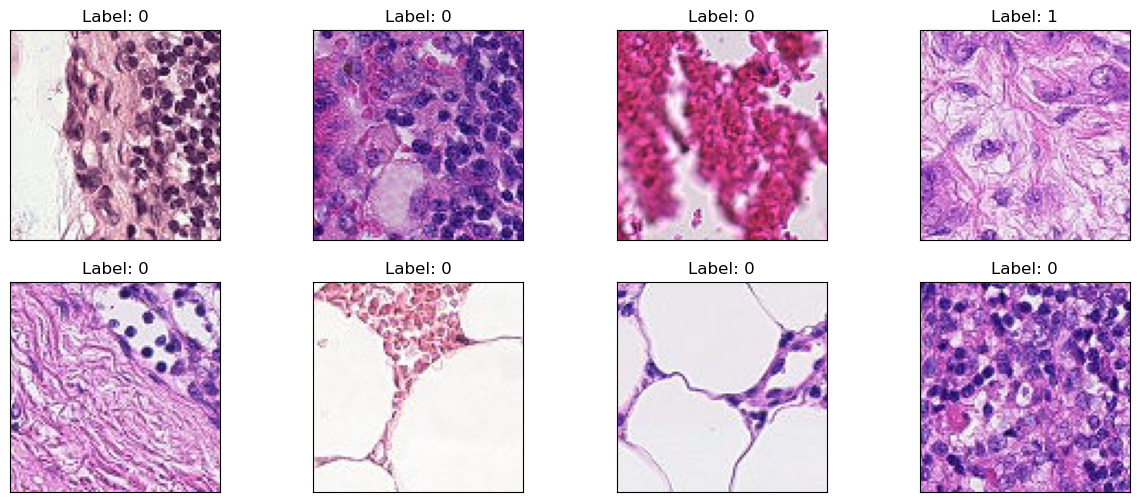

In [23]:
def show_random_images(X, y, num_images=8):
    fig = plt.figure(figsize=(15, 6))
    for i in range(num_images):
        idx = random.randint(0, len(X)-1)
        img = X[idx]
        label = y[idx]
        
        ax = fig.add_subplot(2, num_images//2, i+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(f'Label: {label}')
    
    plt.show()

# Display 8 random images
show_random_images(X, y)


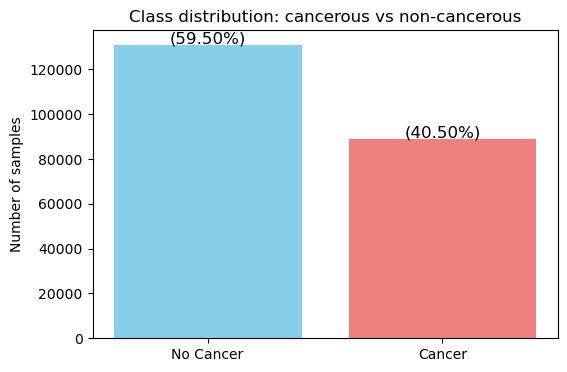

In [51]:
# Check class distribution
class_counts = labels_df['label'].value_counts()
total_samples = len(labels_df)

# Plot class distribution with percentages
class_percentages = (class_counts / total_samples) * 100
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_counts.index, class_counts.values, color=['skyblue', 'lightcoral'])

ax.set_xticks([0, 1])
ax.set_xticklabels(['No cancer', 'Cancer'])
ax.set_ylabel('Number of samples')
ax.set_title('Class distribution: cancerous vs non-cancerous')

for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    ax.text(i, count + 500, f'({percentage:.2f}%)', ha='center', fontsize=12)

plt.show()


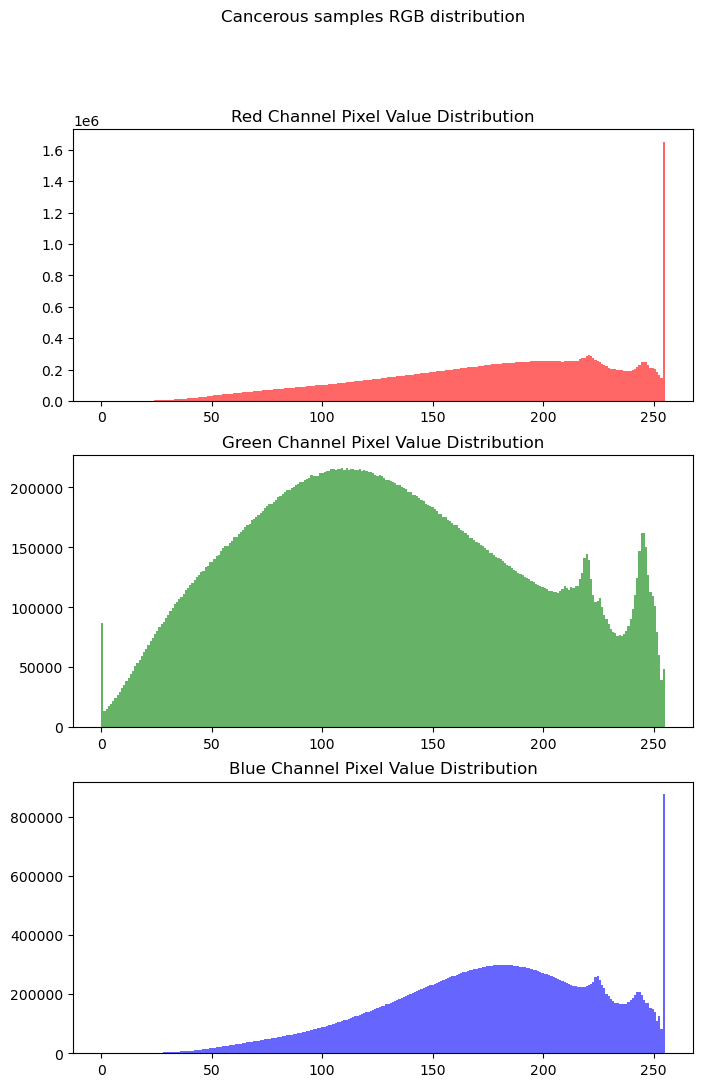

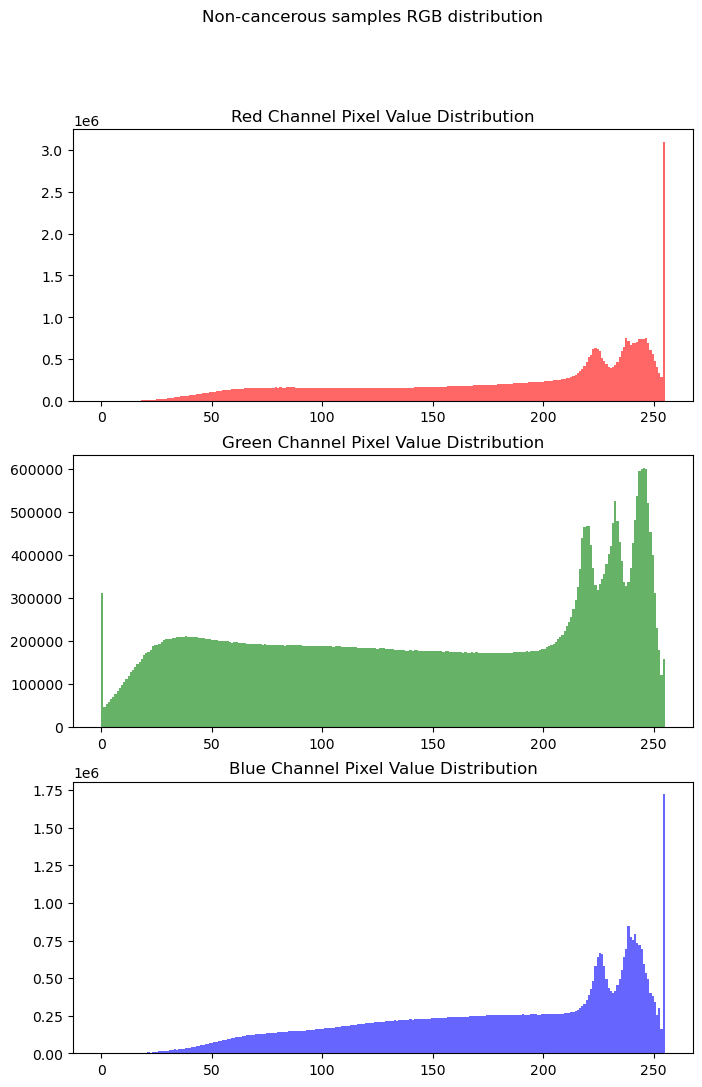

In [54]:
# Split the dataset into cancerous and non-cancerous samples
cancer_samples = X[y == 1]
non_cancer_samples = X[y == 0]

# Plot pixel value distribution across RGB channels for both classes
def plot_rgb_distribution(images, title):
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        axs[i].hist(images[:, :, :, i].flatten(), bins=256, color=color.lower(), alpha=0.6)
        axs[i].set_title(f'{color} Channel Pixel Value Distribution')
    plt.suptitle(title)
    plt.show()

plot_rgb_distribution(cancer_samples, 'Cancerous samples RGB distribution')
plot_rgb_distribution(non_cancer_samples, 'Non-cancerous samples RGB distribution')


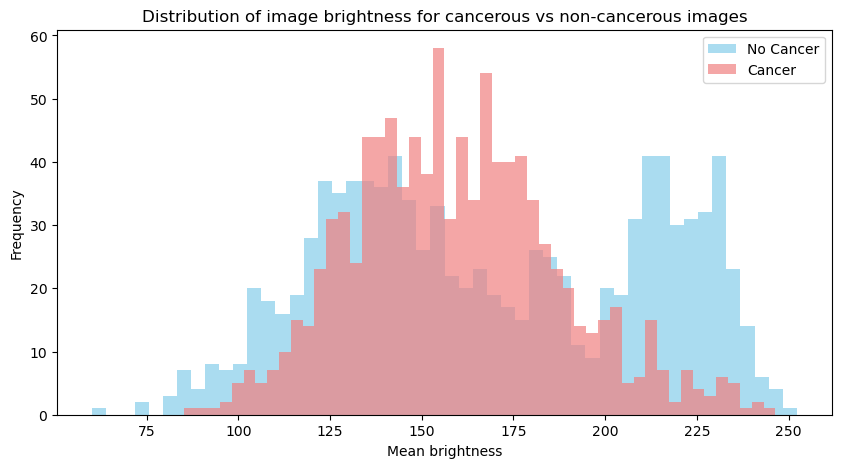

In [53]:
# Load a subset of the dataset  to explore image brightness 
subset_size = 1000
cancer_samples = labels_df[labels_df['label'] == 1]['path'].head(subset_size)
non_cancer_samples = labels_df[labels_df['label'] == 0]['path'].head(subset_size)

import concurrent.futures

# Function to calculate brightness for a batch of images
def calculate_brightness_for_images(image_paths):
    brightness_values = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            brightness_values.append(np.mean(img))
    return brightness_values

# Use ThreadPoolExecutor to parallelise the task and help with long run times
with concurrent.futures.ThreadPoolExecutor() as executor:
    cancer_futures = executor.submit(calculate_brightness_for_images, cancer_samples)
    non_cancer_futures = executor.submit(calculate_brightness_for_images, non_cancer_samples)
    
    cancer_brightness = cancer_futures.result()
    non_cancer_brightness = non_cancer_futures.result()

# Plot brightness distribution for both classes
plt.figure(figsize=(10, 5))

plt.hist(non_cancer_brightness, bins=50, alpha=0.7, color='skyblue', label='No Cancer')
plt.hist(cancer_brightness, bins=50, alpha=0.7, color='lightcoral', label='Cancer')

plt.xlabel('Mean brightness')
plt.ylabel('Frequency')
plt.title('Distribution of image brightness for cancerous vs non-cancerous images')
plt.legend()
plt.show()


#### Analysis

From the above visualisations, I kept 4 takeaways in mind in subsequent steps:

- There are only two classes, so we will be building a binary classifier.
- The dataset is imbalanced, with about 59.5% of images classified as non-cancerous and 40.5% as cancerous. This class imbalance could impact model performance, making it biased towards predicting the majority class (non-cancerous).
- RGB channel distribution for cancerous samples - the overall observation is that cancerous and non-cancerous samples exhibit similar patterns in brightness and colour distribution, but there are subtle differences in the green and red channels, which could serve as key features for classification models.
- Brightness alone is not a strong indicator of cancerous versus non-cancerous images as there is a large amount of overlap in the histogram.

## Preprocessing the data

The following steps were taken to adequately preprocess the data based on the discussed results of the EDA and what would best work for subsequent modelling:

1. Since image resolution is 96x96, we upscale images by an integer multiple (e.g., 2x to 192x192) while ensuring the center region (32x32) remains aligned.

2. Data augmentation, applying basic transformations like flips, rotations, and zooms. Since the orientation of tissue samples under a microscope is generally arbitrary, rotating the images mimics the variability encountered in real-world conditions and helps the model generalise better.These augmentations reduce the risk of overfitting by artificially increasing the diversity of the training set.

3. Data normlisation is crucial in this context as it ensures the CNN model converges faster and performs more consistently - since the medical images, as seen in the EDA, can vary in brightness and contrast. 

In [55]:
def upscale_images(images, scale_factor=2):
    """
    Upscales images by a given scale factor.
    """
    upscaled_images = []
    for img in images:
        upscaled_img = cv2.resize(img, (img.shape[1] * scale_factor, img.shape[0] * scale_factor))
        upscaled_images.append(upscaled_img)
    
    return np.array(upscaled_images)

# Testing - 
upscaled_X = upscale_images(X, scale_factor=2)
print(f"Original image shape: {X[0].shape}, Upscaled image shape: {upscaled_X[0].shape}")


Original image shape: (96, 96, 3), Upscaled image shape: (192, 192, 3)


In [25]:
# Ensure the split is applied on the same dataset (both images and labels)
X_train, X_val, y_train, y_val = train_test_split(upscaled_X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

data_gen = ImageDataGenerator(
    rotation_range=30,     # Rotate the image randomly between 0 and 30 degrees
    width_shift_range=0.1, # Shift image horizontally by 10%
    height_shift_range=0.1, # Shift image vertically by 10%
    zoom_range=0.2,        # Randomly zoom into images by 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,   # Do not flip vertically
    fill_mode='nearest'    # Fill pixels when an image is rotated or shifted
)

train_generator = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=32)




X_train shape: (8000, 192, 192, 3), y_train shape: (8000,)
X_val shape: (2000, 192, 192, 3), y_val shape: (2000,)


In [26]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(upscaled_X, y, test_size=0.2, random_state=42)

# Apply data augmentation to the training data
train_generator = data_gen.flow(X_train, y_train, batch_size=32)

# For validation no augmentation
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

# Checking the shapes of the datasets
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


Training set shape: (8000, 192, 192, 3), Validation set shape: (2000, 192, 192, 3)


## Model 1 Architecture 

Following the EDA and preprocessing, I have taken the decision to first set up a CNN model with three convolutional blocks, followed by a fully connected dense layer, and finally, a sigmoid activation for binary classification (since we’re predicting whether cancer is present or not).

Key features:

Conv2D layers: we start with 32 filters and increase to 64 and 128 in successive layers, allowing the model to learn increasingly complex features.
BatchNormalization: after each convolution, batch normalisation is applied to stabilise and speed up training.
MaxPooling: Reduces the dimensionality of the feature maps by taking the maximum value over a 2x2 region, preserving only the most important features.
Dropout: After each block and dense layer, dropout is applied to prevent overfitting by randomly turning off neurons during training.
Flatten: Converts the 2D matrices into a 1D vector before passing them to the fully connected layer.
Dense: Fully connected layer with 256 units, followed by the final output layer with 1 unit and a sigmoid activation function for binary classification.

This architecture is well-suited for the problem of histopathologic cancer detection as it balances model complexity with regularization. The gradual increase in filters allows for the extraction of progressively more complex features, which is essential for capturing the nuances in histopathologic images.  

In [35]:
def create_cnn_model(input_shape=(192, 192, 3)):
    model = Sequential()

    # First convolutional block: 32 filters
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second convolutional block: 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third convolutional block: 128 filters
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Flattening the 2D matrix into a 1D vector for fully connected layers
    model.add(Flatten())

    # Dense layer and fully connected, with 256 units
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

model = create_cnn_model()


/Users/alex/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 190, 190, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 190, 190, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 95, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 95, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 93, 93, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 93, 93, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 44, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,954,369 (60.86 MB)

 Trainable params: 15,953,921 (60.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),   # Adam optimizer with a learning rate of 0.001
    loss='binary_crossentropy',            # Loss function for binary classification
    metrics=['accuracy']                   # Track accuracy during training
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 190, 190, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 190, 190, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 95, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 95, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 93, 93, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 93, 93, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 44, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,954,369 (60.86 MB)

 Trainable params: 15,953,921 (60.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
# Training the model
history = model.fit(
    train_generator,         # Augmented training data
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=10,               # Number of epochs to train
    validation_data=val_gen,  # Validation data
    validation_steps=len(X_val) // 32,   # Number of batches for validation
    verbose=1                # Display training progress
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 677ms/step - accuracy: 0.6962 - loss: 6.1517 - val_accuracy: 0.6895 - val_loss: 2.2342
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 3.3435
Epoch 3/10


/Users/alex/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


250/250 ━━━━━━━━━━━━━━━━━━━━ 173s 689ms/step - accuracy: 0.7677 - loss: 0.5288 - val_accuracy: 0.7833 - val_loss: 1.5728
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 4.0436
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 174s 694ms/step - accuracy: 0.7893 - loss: 0.4910 - val_accuracy: 0.7424 - val_loss: 1.6296
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.8311
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 674ms/step - accuracy: 0.7842 - loss: 0.4951 - val_accuracy: 0.6941 - val_loss: 0.6392
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3790
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 176s 702ms/step - accuracy: 0.7899 - loss: 0.4866 - val_accuracy: 0.8075 - val_loss: 0.5633
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.

In [38]:
# Evaluating the model on the validation set

val_loss, val_acc = model.evaluate(val_gen, steps=len(X_val) // 32)
print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.8011 - loss: 0.5844
Validation Accuracy: 0.8085, Validation Loss: 0.5650


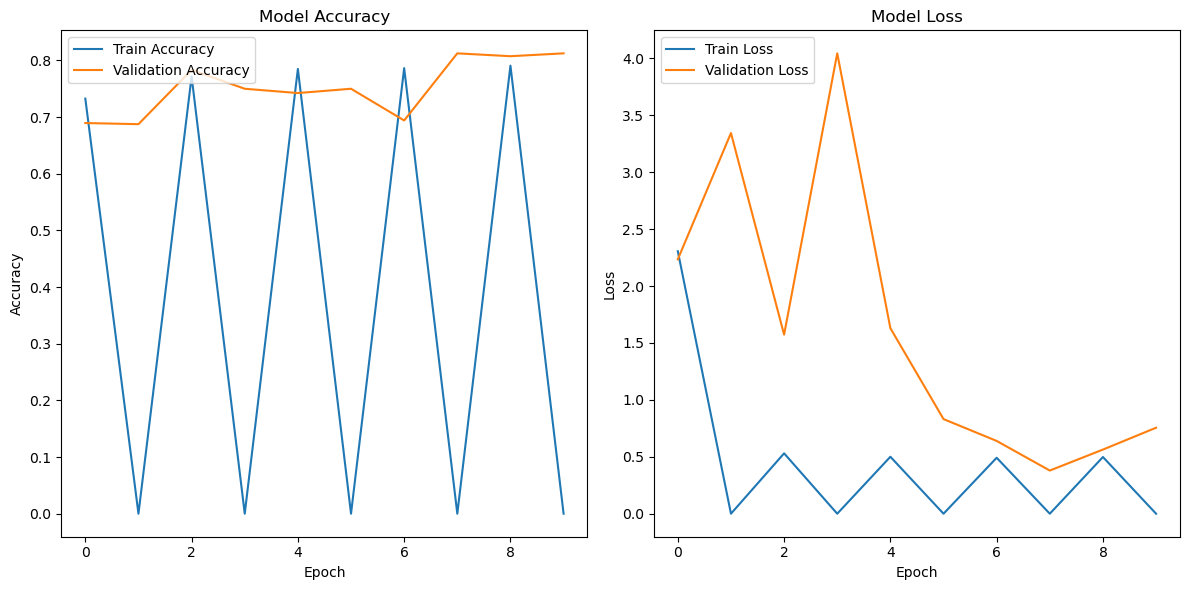

In [42]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [44]:
base_test_dir = base_test_dir = '/Users/alex/Desktop/github_projects/histopathologic-cancer-detection/histopathologic-cancer-detection/test/'  # specify test data folder
test_files = glob(os.path.join(base_test_dir, '*.tif'))  # Get the list of test image files

submission = pd.DataFrame()  
file_batch = 5000  # Process 5000 images in batches as per other kernel's approaches (cited in introduction)
max_idx = len(test_files) 

# Iterate over test image batches and make predictions
for idx in range(0, max_idx, file_batch):
    print(f"Processing batch {idx} to {min(idx + file_batch, max_idx)}")

    test_df = pd.DataFrame({'path': test_files[idx:idx + file_batch]})
    test_df['id'] = test_df['path'].map(lambda x: os.path.basename(x).split(".")[0])
    
    # Load and preprocess the batch of images
    test_df['image'] = test_df['path'].map(lambda img_path: cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (192, 192)))
    K_test = np.stack(test_df['image'].values)
    K_test = K_test / 255.0
    
    predictions = model.predict(K_test, verbose=1)
    
    # Store the predictions in the DataFrame
    test_df['label'] = predictions.flatten()  # Flatten the predictions
    
    # Concatenate results to the submission DataFrame
    submission = pd.concat([submission, test_df[['id', 'label']]])

submission.to_csv("submission1.csv", index=False, header=True)
submission.head()


Processing batch 0 to 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step
Processing batch 5000 to 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step
Processing batch 10000 to 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step
Processing batch 15000 to 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step
Processing batch 20000 to 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step
Processing batch 25000 to 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step
Processing batch 30000 to 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step
Processing batch 35000 to 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step
Processing batch 40000 to 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step
Processing batch 45000 to 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step
Processing batch 50000 to 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step
Processing batch 55000 to 57458
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.063239
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.064005
2,19709bec800f372d0b1d085da6933dd3ef108846,0.064155
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.064803
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.064232


Kaggle score

Score: 0.3244
Private score: 0.3312

### Analysis:

Validation accuracy is lower than training accuracy, and fluctuates significantly after each epoch. This suggests some degree of overfitting.
Validation loss fluctuates and is higher than training loss, indicating that the model struggles to generalise well on unseen data.

To address these issues, we can implement a series of modifications to improve the model's performance, prevent overfitting, and optimize generalization.


## Model 2 Architecture 

This model is similar to the first, however, it uses custom progress tracking and a custom training loop rather than Keras' default fit method. This gives Model 2 control over the training process which is useful for understanding how the model is learning and makes sense to do early on in this project.

This model was insipired by an existing kernel: https://www.kaggle.com/code/hrmello/base-cnn-classification-from-scratch?scriptVersionId=7628679 For Model 2, we used the custom training loop to fine tune the batch size and epochs.


In [55]:
epochs = 3 

for epoch in range(epochs):
    iterations = np.floor(split_idx / batch_size).astype(int) 
    loss,acc = 0,0 
    
    # Displaying a progress bar
    with trange(iterations) as t: 
        for i in t:
            start_idx = i * batch_size 
            x_batch = X[start_idx:start_idx+batch_size] 
            y_batch = y[start_idx:start_idx+batch_size] 

            metrics = model.train_on_batch(x_batch, y_batch) 

            loss = loss + metrics[0] 
            acc = acc + metrics[1] 
            t.set_description('Running training epoch ' + str(epoch)) 
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

Running training epoch 0: 100%|█| 160/160 [02:03<00:00,  1.29it/s, acc=0.74, los
Running training epoch 1: 100%|█| 160/160 [02:10<00:00,  1.23it/s, acc=0.79, los
Running training epoch 2: 100%|█| 160/160 [02:01<00:00,  1.32it/s, acc=0.81, los


In [58]:
X = None
y = None
gc.collect();

In [56]:
# Computing how many batches are needed

iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int)
loss,acc = 0,0

with trange(iterations) as t: 
    
    for i in t:
        start_idx = i * batch_size 
        x_batch = X[start_idx:start_idx+batch_size] 
        y_batch = y[start_idx:start_idx+batch_size] 
        
        metrics = model.test_on_batch(x_batch, y_batch)
        
        loss = loss + metrics[0] 
        acc = acc + metrics[1] 
        t.set_description('Running training') 
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation: 100%|██| 40/40 [00:10<00:00,  3.96it/s, acc=0.81, loss=0.45]

Validation loss: 0.44838602766394614
Validation accuracy: 0.812116539478302


In [61]:
# Preparing submission

base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir, '*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files)  

for idx in range(0, max_idx, file_batch):  # iterate over test image batches
    print("Indexes: %i - %i" % (idx, idx + file_batch))
    
    
    test_df = pd.DataFrame({'path': test_files[idx:idx + file_batch]})
    test_df['id'] = test_df['path'].map(lambda x: os.path.basename(x).split(".")[0])
    test_df['image'] = test_df['path'].map(lambda img_path: cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    
    K_test = np.stack(test_df["image"].values)  
    K_test = K_test / 255.0  
    
    predictions = model.predict(K_test, verbose=1)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])

submission.head()

Indexes: 0 - 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
Indexes: 5000 - 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
Indexes: 10000 - 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step
Indexes: 15000 - 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
Indexes: 20000 - 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
Indexes: 25000 - 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
Indexes: 30000 - 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step
Indexes: 35000 - 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
Indexes: 40000 - 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
Indexes: 45000 - 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
Indexes: 50000 - 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step
Indexes: 55000 - 60000
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.117617
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.116929
2,19709bec800f372d0b1d085da6933dd3ef108846,0.117506
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.117653
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.118393


In [62]:
submission.to_csv("submission.csv", index=False, header=True)

Kaggle score

Score: 0.5944
Private score: 0.6124

### Analysis 

This leaves room for improvement - overall, having played with various batch sizes I was not able to improve this model without running into significant waiting times or memory outtages. 

## Model 3 Architecture:

In this model, I use the Keras tuner library to automate the search for the best hyperparameter on the first model, in an aim to improve convergence.

Reloading Tuner from my_dir/cnn_hyperparam_tuning/tuner0.json
Best Learning Rate: 0.01
Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 200s 704ms/step - accuracy: 0.7074 - loss: 1.6259 - val_accuracy: 0.6090 - val_loss: 0.8851
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 193s 684ms/step - accuracy: 0.7838 - loss: 0.6664 - val_accuracy: 0.5440 - val_loss: 2.0417
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 188s 665ms/step - accuracy: 0.7968 - loss: 0.5859 - val_accuracy: 0.6730 - val_loss: 0.7616
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 196s 694ms/step - accuracy: 0.8038 - loss: 0.5750 - val_accuracy: 0.6520 - val_loss: 0.7874
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 190s 673ms/step - accuracy: 0.8039 - loss: 0.5411 - val_accuracy: 0.8260 - val_loss: 0.5026
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 192s 680ms/step - accuracy: 0.8180 - loss: 0.5081 - val_accuracy: 0.6490 - val_loss: 0.8523
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 196s 694ms/step - accuracy: 0.8155 - loss: 0.4915 - val_accuracy: 0.7260 - val_lo

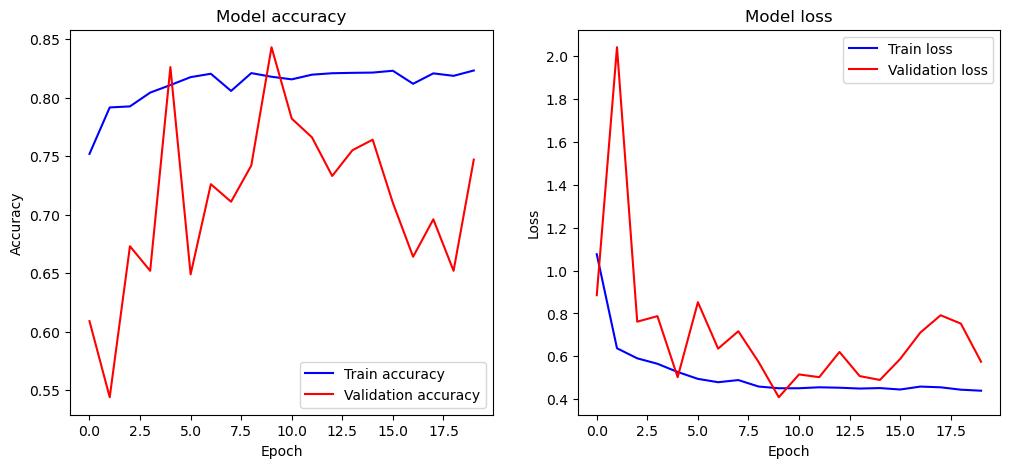

In [36]:
def model_builder(hp):
    model = create_cnn_model()
    
    # Tuning the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='cnn_hyperparam_tuning'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=20, 
    verbose=1
)

# Plotting results 
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [ ]:
Kaggle score

Score: 0.6457
Private score: 0.6611

### Analysis

The tuned model may be over regularised which would explain these results  Furthermore, the extra complexity may be causing the model to overfit.

The training accuracy is high and quite smooth, but the validation accuracy is inconsistent and relatively low. This indicates overfitting, meaning the model has learned the training data well but isn't able to generalize to unseen data. The erraticness could be due to noise in the validation data that the hyperparameter tuning process optimised for. 

## Model 4 Architecture:

This model I have summarised into one final approach in order to not over-busy this document. However the approach I took was to systematically work through the features in Model 1 that could be improved, testing each one guided either by experimentation or also by logically inferring what could contribute positively to the model. The final model put together the things that worked in this process:

##### Adding another convolutional layer to allow the model to capture more complex features.
##### Adding L2 regularization to combat overfitting by penalizing large weights.
##### Slightly reducing the dropout to retain more information during training.
##### Implementing a learning rate scheduler to adjust the learning rate as training progresses, which can help stabilise training.

These are the cumulative product of iterations that tested each of these features independently. 

In [27]:
def create_cnn_model(input_shape=(192, 192, 3)):
    model = Sequential()

    # First convolutional block: 32 filters
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Second convolutional block: 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Third convolutional block: 128 filters
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Fourth convolutional block: 256 filters (new layer for deeper feature extraction)
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # GlobalAveragePooling2D layer to automatically adjust flattening
    model.add(GlobalAveragePooling2D())

    # Fully connected layer with 512 units (increase units for more capacity)
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

model = create_cnn_model()
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

# Learning rate scheduler to reduce learning rate when a plateau is reached
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)


history = model.fit(
    train_generator,         # Augmented training data
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=20,               # Increased number of epochs to train
    validation_data=val_gen,  # Validation data
    validation_steps=len(X_val) // 32,   # Number of batches for validation
    callbacks=[lr_scheduler], # Include learning rate scheduler
    verbose=1                # Display training progress
)



/Users/alex/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/Users/alex/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 186s 737ms/step - AUC: 0.8017 - accuracy: 0.7447 - loss: 1.1431 - val_AUC: 0.6748 - val_accuracy: 0.6321 - val_loss: 1.3520 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.7302 - val_accuracy: 0.5625 - val_loss: 1.4757 - learning_rate: 0.0010
Epoch 3/20


2024-09-27 16:50:19.388005: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/alex/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-27 16:50:19.546224: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 735ms/step - AUC: 0.8594 - accuracy: 0.7961 - loss: 0.7986 - val_AUC: 0.8310 - val_accuracy: 0.6815 - val_loss: 0.8437 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.8730 - val_accuracy: 0.6250 - val_loss: 0.9137 - learning_rate: 0.0010
Epoch 5/20


2024-09-27 16:53:24.288578: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 735ms/step - AUC: 0.8741 - accuracy: 0.8073 - loss: 0.6319 - val_AUC: 0.8732 - val_accuracy: 0.7490 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.8095 - val_accuracy: 0.6250 - val_loss: 0.8680 - learning_rate: 0.0010
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 711ms/step - AUC: 0.8829 - accuracy: 0.8170 - loss: 0.5518 - val_AUC: 0.7577 - val_accuracy: 0.7268 - val_loss: 0.7901 - learning_rate: 0.0010
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.8667 - val_accuracy: 0.8125 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 9/20


2024-09-27 16:59:27.721594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 687ms/step - AUC: 0.8906 - accuracy: 0.8175 - loss: 0.5085 - val_AUC: 0.9153 - val_accuracy: 0.8453 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.9167 - val_accuracy: 0.8750 - val_loss: 0.4849 - learning_rate: 0.0010
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 748ms/step - AUC: 0.8896 - accuracy: 0.8152 - loss: 0.4877 - val_AUC: 0.9070 - val_accuracy: 0.8342 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.9273 - val_accuracy: 0.8125 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 193s 769ms/step - AUC: 0.9042 - accuracy: 0.8346 - loss: 0.4482 - val_AUC: 0.8219 - val_accuracy: 0.7681 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 14/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 315

2024-09-27 17:11:47.534141: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 709ms/step - AUC: 0.9071 - accuracy: 0.8315 - loss: 0.4274 - val_AUC: 0.8827 - val_accuracy: 0.8256 - val_loss: 0.4745 - learning_rate: 5.0000e-04
Epoch 18/20

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.8889 - val_accuracy: 0.9375 - val_loss: 0.4819 - learning_rate: 5.0000e-04
Epoch 19/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 175s 695ms/step - AUC: 0.9128 - accuracy: 0.8497 - loss: 0.4086 - val_AUC: 0.9176 - val_accuracy: 0.8533 - val_loss: 0.3977 - learning_rate: 2.5000e-04
Epoch 20/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.9500 - val_accuracy: 0.9375 - val_loss: 0.3269 - learning_rate: 2.5000e-04


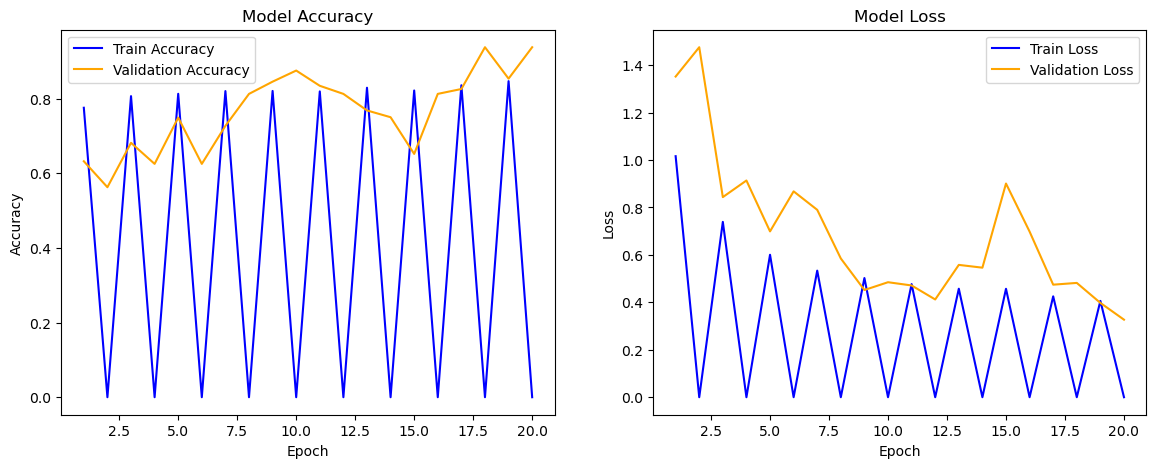

In [31]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [34]:
# Submission process

base_test_dir = '/Users/alex/Desktop/github_projects/histopathologic-cancer-detection/histopathologic-cancer-detection/test/'  # specify test data folder
test_files = glob(os.path.join(base_test_dir, '*.tif'))  

submission = pd.DataFrame() 
file_batch = 5000  
max_idx = len(test_files)  

for idx in range(0, max_idx, file_batch):
    print(f"Processing batch {idx} to {min(idx + file_batch, max_idx)}")
    test_df = pd.DataFrame({'path': test_files[idx:idx + file_batch]})
    test_df['id'] = test_df['path'].map(lambda x: os.path.basename(x).split(".")[0])
    test_df['image'] = test_df['path'].map(lambda img_path: cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (192, 192)))
    K_test = np.stack(test_df['image'].values)  
    K_test = K_test / 255.0
    
    predictions = model.predict(K_test, verbose=1)
    test_df['label'] = predictions.flatten()
    submission = pd.concat([submission, test_df[['id', 'label']]])

submission.to_csv("submission.csv", index=False, header=True)

submission.head()
print(f"Found {len(test_files)} test images.")



Processing batch 0 to 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step
Processing batch 5000 to 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step
Processing batch 10000 to 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step
Processing batch 15000 to 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step
Processing batch 20000 to 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step
Processing batch 25000 to 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step
Processing batch 30000 to 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step
Processing batch 35000 to 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step
Processing batch 40000 to 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step
Processing batch 45000 to 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step
Processing batch 50000 to 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step
Processing batch 55000 to 57458
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step
Found 57458 test images.


Kaggle score

Score: 0.7512
Private score: 0.7625

### Analysis

The train loss erratic changes are due to memory encountered issues from my device. 

The validation accuracy trend is much smoother and consistent compared to the training accuracy. It shows a gradual increase, indicating the model is learning and generalizing reasonably well. It also decreases steadily over time, which is a positive sign of generalization and convergence.

The Kaggle score is the highest reached to-date.

## Model summary and results

In [66]:
data = {
    'Model': [
        'Basic CNN Architecture', 
        'Custom Training Loop', 
        'Tuned Model with Dropout', 
        'Deep Architecture with Large Filters'
    ],
    'Score': [0.3244, 0.5944, 0.6457, 0.7512],
    'Private Score': [0.3312, 0.6124, 0.6611, 0.7625],
    'Validation Accuracy': [0.8012, 0.8121, 0.8298, 0.8497],
    'Epochs': [10, 3, 20, 20],
    'Learning Rate': [0.001, 0.001, 0.01, 0.001]
}

summary_df = pd.DataFrame(data, index=[1, 2, 3, 4])

summary_df


,Model,Score,Private Score,Validation Accuracy,Epochs,Learning Rate
1,Basic CNN Architecture,0.3244,0.3312,0.8012,10,0.001
2,Custom Training Loop,0.5944,0.6124,0.8121,3,0.001
3,Tuned Model with Dropout,0.6457,0.6611,0.8298,20,0.010
4,Deep Architecture with Large Filters,0.7512,0.7625,0.8497,20,0.001


### Analysis

The initial "Basic CNN Architecture" provided a foundation with decent accuracy (80.12%) but struggled with overfitting. The model performed well on training data but showed fluctuations in validation performance.

Troubleshooting steps included reviewing learning curves and validation loss trends, which helped identify the need for adjustments like increasing dropout to counter overfitting and reducing learning rates for smoother training. The custom training loop in Model 2 allowed more granular control over how the model learned, although it required more effort in tuning. Model 4 introduced dropout layers and increased depth, leading to a better balance between training and validation accuracy.

Hyperparameter tuning in Model 3 involved testing learning rates and dropout rates systematically. While the deep model achieved the highest validation accuracy (84.97%), tuning learning rates did not always lead to improvements, with higher learning rates sometimes causing more variability in validation accuracy.


### Conclusion

The results demonstrate that increasing model complexity with more convolutional layers and tuning hyperparameters improved performance, but only up to a point. The deeper architecture in Model 4 achieved the highest scores, though it required more time for training. A key takeaway is the importance of balancing model depth and regularisation (e.g., dropout) to prevent overfitting.

One of the challenges encountered was the instability of validation accuracy during training, even after tuning learning rates and dropout. Future improvements could involve experimenting with additional data augmentation strategies (such as image rotations) to increase robustness, or implementing more advanced optimization and normalisation techniques like early stopping or learning rate scheduling to avoid overfitting and improve generalisation further.